In [4]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/home/ricardormotta/projects/LTV_analysis/ltv-ml-project/conf/local/gcp_token.json"


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.calibration import calibration_curve 
from sklearn.metrics import brier_score_loss
from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier
import lifelines

from sklearn.model_selection import GridSearchCV


In [2]:
X_train = catalog.load("X_train")
X_test = catalog.load("X_test")
y_train = catalog.load("y_train")
y_test = catalog.load("y_test")
CT = catalog.load("CT")

[11/27/23 20:48:17] INFO     Loading data from 'X_train' (CSVDataSet)...                        ]8;id=819496;file:///home/ricardormotta/projects/LTV_analysis/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=474174;file:///home/ricardormotta/projects/LTV_analysis/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /home/ricardormotta/projects/LTV_analysis/venv/lib/python3.10/site-packages/kedro/io/core.py:193 │
│ in load                                                                                          │
│                                                                                                  │
│   190 │   │   self._logger.debug("Loading %s", str(self))                                        │
│   191 │   │                                                                                      │
│   192 │   │   try:                                                                               │
│ ❱ 193 │   │   │   return self._load()                                                            │
│   194 │   │   except DatasetError:                                                               │
│   195 │   │   │   raise                                                                          │
│   196 │   │   except Exception as exc:                                                           │
│                                                                                                  │
│ /home/ricardormotta/projects/LTV_analysis/venv/lib/python3.10/site-packages/kedro/extras/dataset │
│ s/pandas/csv_dataset.py:160 in _load                                                             │
│                                                                                                  │
│   157 │   │   │   # (<urlopen error file not on local host>),                                    │
│   158 │   │   │   # so we don't join that back to the filepath;                                  │
│   159 │   │   │   # storage_options also don't work with local paths                             │
│ ❱ 160 │   │   │   return pd.read_csv(load_path, **self._load_args)                               │
│   161 │   │                                                                                      │
│   162 │   │   load_path = f"{self._protocol}{PROTOCOL_DELIMITER}{load_path}"                     │
│   163 │   │   return pd.read_csv(                                                                │
│                                                                                                  │
│ /home/ricardormotta/projects/LTV_analysis/venv/lib/python3.10/site-packages/pandas/io/parsers/re │
│ aders.py:948 in read_csv                                                                         │
│                                                                                                  │
│    945 │   )                                                                                     │
│    946 │   kwds.update(kwds_defaults)                                                            │
│    947 │                                                                                         │
│ ❱  948 │   return _read(filepath_or_buffer, kwds)                                                │
│    949                                                                                           │
│    950                                                                                           │
│    951 # iterator=True -> TextFileReader                                                         │
│                                                                                                  │
│ /home/ricardormotta/projects/LTV_analysis/venv/lib/python3.10/site-packages/pandas/io/parsers/re │
│ aders.py:611 in _read                                                                            │
│                                                                                                  │
│    608 │   _validate_names(kwds.get("names", None))                                              │
│    609 │                                                                                         │
│    610 │   # Create the parser.                            

In [7]:
# calculate the fpr and tpr for all thresholds of the classification
def plot_ROC(_pipe, _X, _y, ax, color, dataset_name): 
    probs = _pipe.predict_proba(_X)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(_y, preds)
    roc_auc = metrics.auc(fpr, tpr)
    # method I: plt
    ax.set_title(f'ROC Curve: {type(pipe["model"]).__name__}')
    ax.plot(fpr, tpr, color=color, label = f'AUC {dataset_name} = {round(roc_auc, 5)}')
    ax.legend(loc = 'lower right')
    ax.plot([0, 1], [0, 1],'--', color="black")
    ax.set_xlim([-0.01, 1.01])
    ax.set_ylim([-0.01, 1.01])
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')
    return ax


def plot_confusion_matrix(_pipe, _X, _y, ax, dataset_name="Test"):
    # Predict labels using the provided model
    _y_pred = _pipe.predict(_X)
    
    # Generate confusion matrix
    cm = metrics.confusion_matrix(_y, _y_pred)
    
    # Plotting the confusion matrix using seaborn heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=pipe["model"].classes_, yticklabels=pipe["model"].classes_, ax=ax)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title(f'Confusion Matrix')
    return ax

def plot_ROC_and_confusion_matrix(pipe, X_train, X_test, y_train, y_test):
    palette = sns.color_palette()
    fig, axs = plt.subplots(1, 2, figsize=(14,6))
    plot_ROC(pipe, X_test, y_test, ax=axs[0], color=palette[0], dataset_name="Test")
    plot_ROC(pipe, X_train, y_train, ax=axs[0], dataset_name="Train", color=palette[1])

    plot_confusion_matrix(pipe, X_test, y_test, ax=axs[1])
    plt.tight_layout()
    
    plt.show()
    plt.close()
    return fig

[11/26/23 12:56:27] WARNING  /home/ricardormotta/projects/LTV_analysis/venv/lib/python3.10/site-pac ]8;id=365204;file:///usr/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=647066;file:///usr/lib/python3.10/warnings.py#109\109]8;;\
                             kages/sklearn/base.py:1152: DataConversionWarning: A column-vector y                  
                             was passed when a 1d array was expected. Please change the shape of y                 
                             to (n_samples,), for example using ravel().                                           
                               return fit_method(estimator, *args, **kwargs)                                       
                                                                                                                   

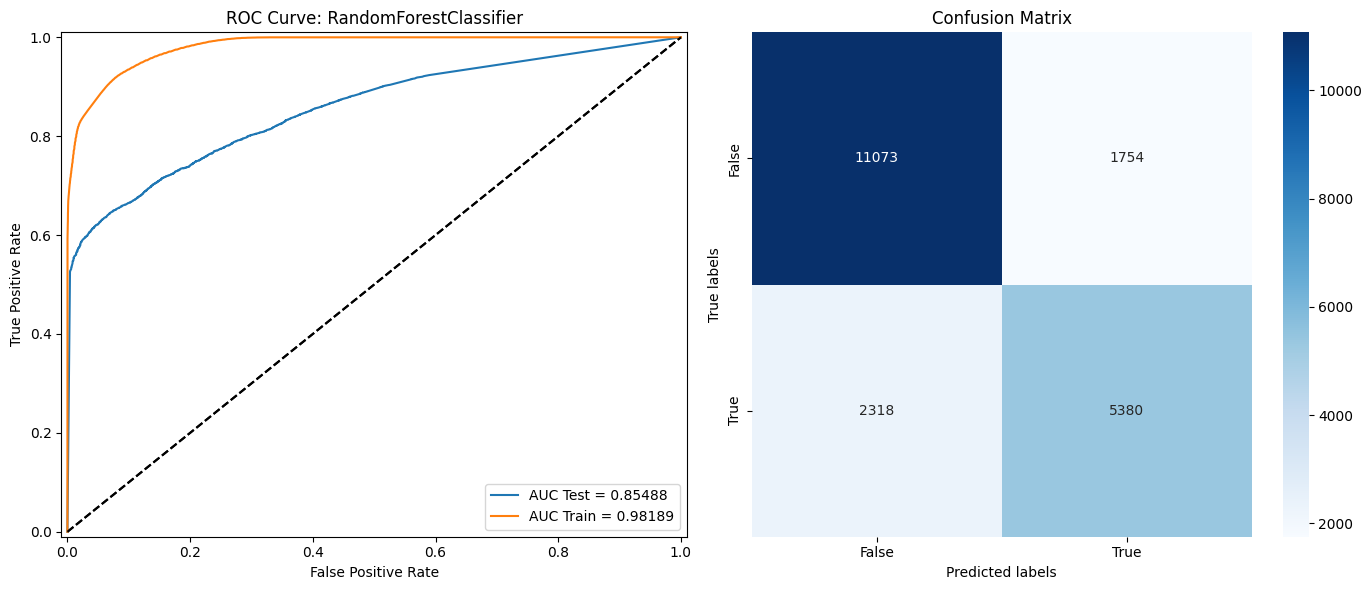

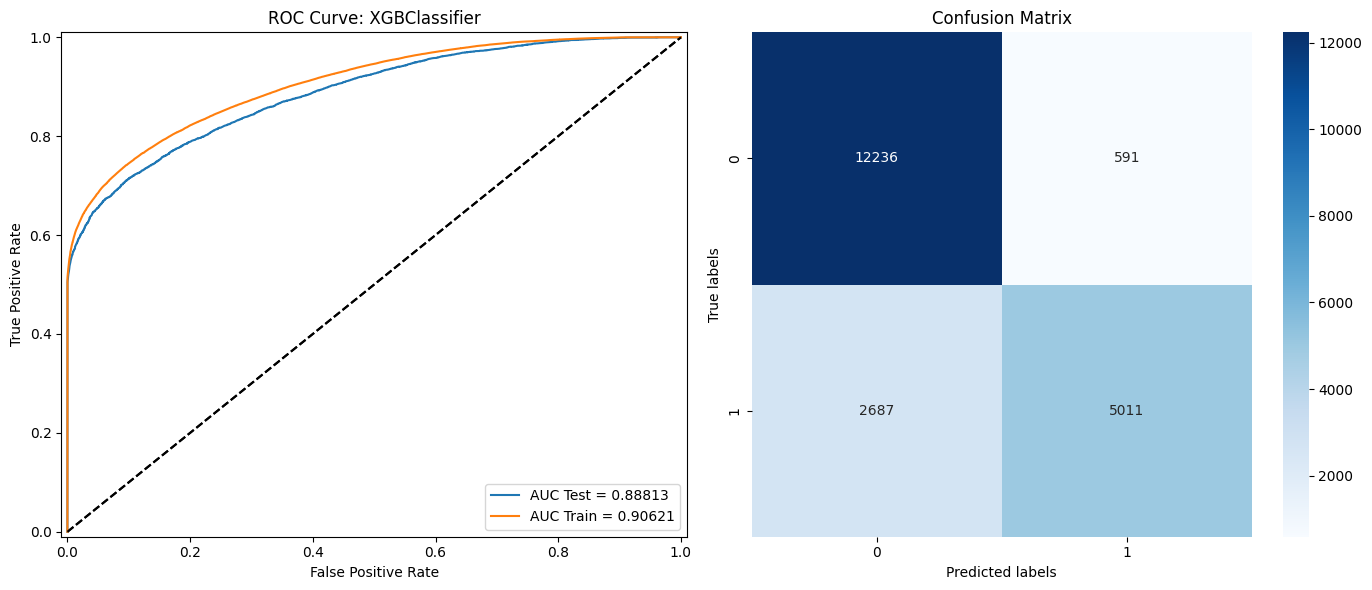

[11/26/23 12:56:36] WARNING  /home/ricardormotta/projects/LTV_analysis/venv/lib/python3.10/site-pac ]8;id=90646;file:///usr/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=153738;file:///usr/lib/python3.10/warnings.py#109\109]8;;\
                             kages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A                           
                             column-vector y was passed when a 1d array was expected. Please change                
                             the shape of y to (n_samples, ), for example using ravel().                           
                               y = column_or_1d(y, warn=True)                                                      
                                                                                                                   

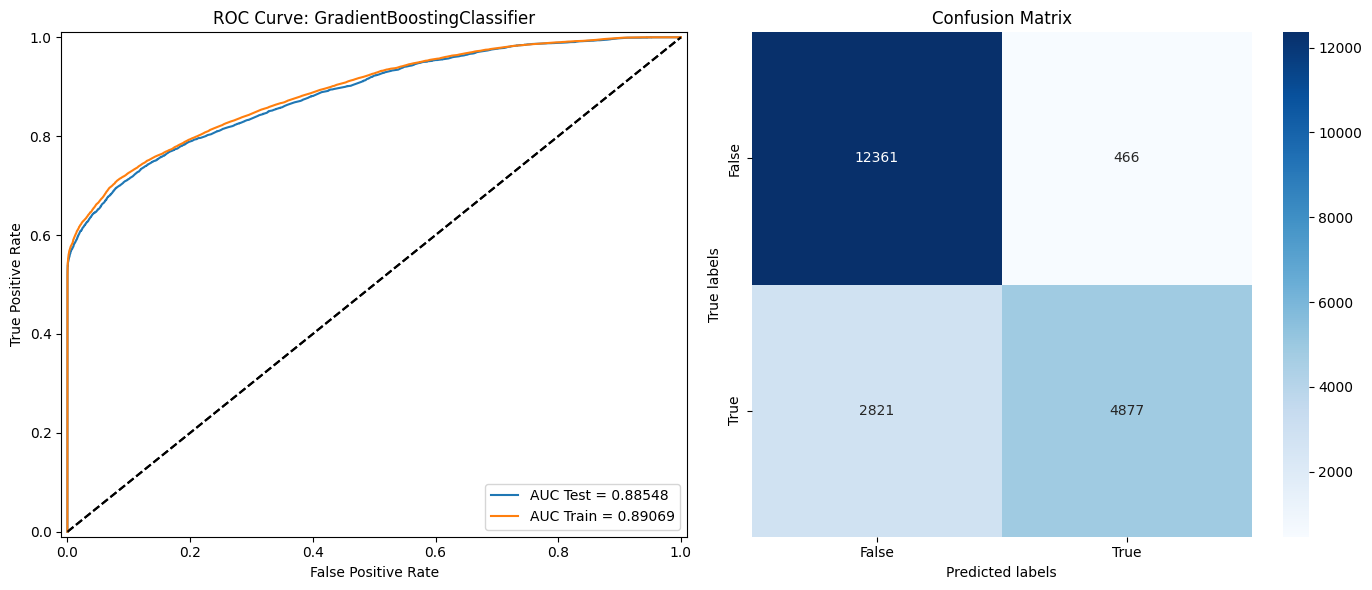

In [8]:
models = [
    RandomForestClassifier(),
    XGBClassifier(),
    GradientBoostingClassifier()
]
for model in models:
    pipe = Pipeline([
        ("CT", CT),
        ("model", model)
    ])
    
    pipe.fit(X_train, y_train)
    plot_ROC_and_confusion_matrix(pipe, X_train, X_test, y_train, y_test)


In [9]:
xgb = XGBClassifier()
parameters = {
    "n_estimators": [250, 400, 500],
    "max_depth": [4, 6, 8]
}
clf = GridSearchCV(xgb, parameters, n_jobs=-1, verbose=3)
pipe = Pipeline([
    ("CT", CT),
    ("model", clf)
])
pipe.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


Pipeline(steps=[('CT',
                 ColumnTransformer(transformers=[('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['product', 'channel',
                                                   'age_bucket',
                                                   'operating_system']),
                                                 ('numerical', StandardScaler(),
                                                  ['days_to_churn', 'product_x',
                                                   'product_y'])])),
                ('model',
                 GridSearchCV(estimator=XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=Non...
                                                      max_bin=None,
                                                      max_cat_threshold=None,
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...),
                              n_jobs=-1,
                              param_grid={'max_depth': [4, 6, 8],
                                          'n_estimators': [250, 400, 500]},
                              verbose=3))])

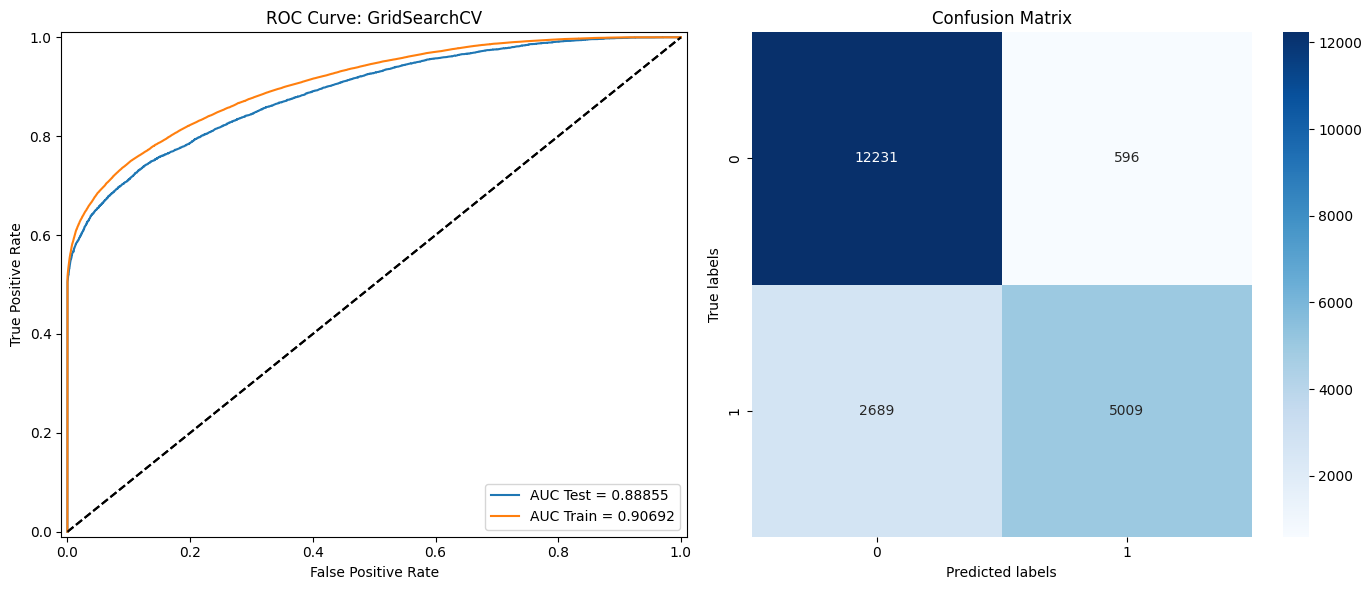

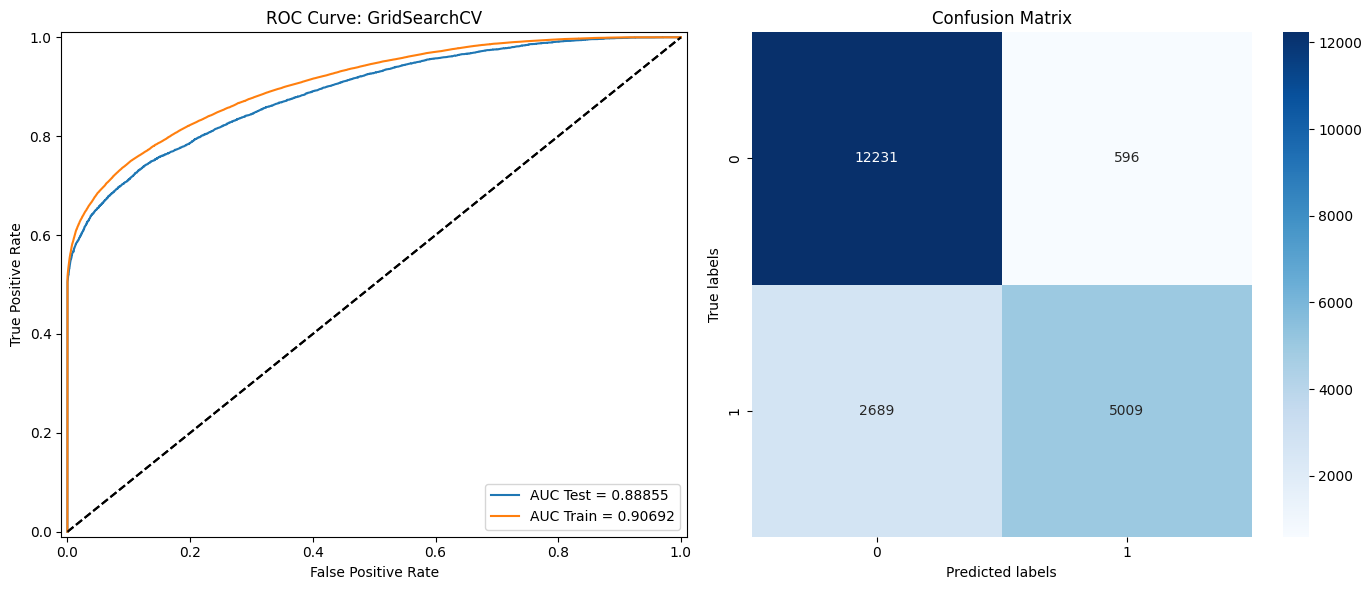

In [10]:
plot_ROC_and_confusion_matrix(pipe, X_train, X_test, y_train, y_test)

In [11]:
pipe["model"].best_params_

{'max_depth': 4, 'n_estimators': 400}

[CV 2/5] END .....max_depth=4, n_estimators=400;, score=0.842 total time=   3.6s
[CV 5/5] END .....max_depth=6, n_estimators=250;, score=0.843 total time=   2.7s
[CV 4/5] END .....max_depth=6, n_estimators=500;, score=0.841 total time=   6.1s
[CV 4/5] END .....max_depth=4, n_estimators=400;, score=0.844 total time=   3.5s
[CV 1/5] END .....max_depth=6, n_estimators=400;, score=0.843 total time=   4.6s
[CV 3/5] END .....max_depth=8, n_estimators=250;, score=0.840 total time=   4.1s
[CV 4/5] END .....max_depth=4, n_estimators=250;, score=0.843 total time=   2.4s
[CV 2/5] END .....max_depth=6, n_estimators=250;, score=0.839 total time=   2.7s
[CV 5/5] END .....max_depth=6, n_estimators=400;, score=0.842 total time=   4.5s
[CV 1/5] END .....max_depth=8, n_estimators=400;, score=0.837 total time=   6.1s
[CV 2/5] END .....max_depth=4, n_estimators=500;, score=0.841 total time=   4.9s
[CV 4/5] END .....max_depth=6, n_estimators=400;, score=0.842 total time=   4.8s
[CV 2/5] END .....max_depth=